# Diversity factor calculation for load profiles

## Configuration

In [472]:
DATA = "../data/consumption.csv"        # CSV with load user load profiles
SAMPLESIZE = 100                        # Number of independent samples to use to estimate averages
NUMBOOTSTRAP = 2000                     # Number of bootstrap resampling steps
STEPFACTOR = 2                          # Aggregation level step size (multiplicative, i.e. 3 gives 1,3,9,...)

## Load packages and data

In [473]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as pyplot
import scipy.stats as stats

In [474]:
dataframe = pandas.read_csv(DATA, index_col=0)

## Sampling and diversity factor calculation

In [475]:
# determine the number of aggregation levels according to the size of the dataset and the STEPFACTOR
aggregation_steps = 1 + math.floor(math.log(len(dataframe.columns))/math.log(STEPFACTOR))
# calculate the aggregation levels, starting at 1
aggregation_levels = [STEPFACTOR**i for i in range(aggregation_steps)]

In [476]:
# initialise result array
diversity_factor_array = np.zeros((len(aggregation_levels), SAMPLESIZE))
# for every aggregation level and sample count
for agg_step, households in enumerate(aggregation_levels):
    for i in range(SAMPLESIZE):
        # sample 'households' with replacement
        sample = dataframe.sample(n=households, axis='columns', replace=True)
        # calculate diversity factor
        peak_aggregate_demand = sample.sum(axis='columns').max()
        sum_of_peak_demand = sample.max().sum()
        if peak_aggregate_demand > 1e-5:
            diversity_factor = sum_of_peak_demand / peak_aggregate_demand
        else:
            # define DF=1.0 when peak aggregate demand is zero or negative
            diversity_factor = 1.0
        # store value in array
        diversity_factor_array[agg_step, i] = diversity_factor


## Postprocessing

In [481]:
# calculate sample average for each aggregation level
average_diversity_factor = diversity_factor_array.mean(axis=1)

# identify sample sets with non-identical values (usually all other than aggregation level = 1)
bootstrap_filter = (np.equal(diversity_factor_array[:,0:1], diversity_factor_array).all(axis=1) == False)
# apply BCa bootstrap analysis
bootstrap_stats = stats.bootstrap((diversity_factor_array[bootstrap_filter],), np.mean, n_resamples=NUMBOOTSTRAP, axis=1, vectorized=True)

# extract bootstrap standard errors (and use zero where all samples are identical)
standard_error = np.zeros(aggregation_steps)
standard_error[bootstrap_filter] = bootstrap_stats.standard_error

# extract absolute up / down errors
diversity_factor_errors = np.zeros((2,aggregation_steps))
diversity_factor_errors[0, bootstrap_filter] = average_diversity_factor[bootstrap_filter] - bootstrap_stats.confidence_interval.low
diversity_factor_errors[1, bootstrap_filter] = bootstrap_stats.confidence_interval.high - average_diversity_factor[bootstrap_filter]

## Output

In [483]:
def round_se(x, se):
    """
    Helper function to print value with its standard error, in decimal notation

    Parameters
    ----------
    x : float
        value to be printed
    se : float
        standard error of x

    Returns
    -------
    string
        Output of type "x (se)" with appropriate number of digits
    """
    if (se > 0):
        # determine number of digits to the left of the decimal point for x and se
        digits_x = int(math.floor(math.log10(abs(x))))
        digits_se = int(math.floor(math.log10(abs(se))))
        # compute the number of significant digits for x
        digits = digits_x - digits_se + 2
        # construct return string
        return f"{np.format_float_positional(x, precision=digits, fractional=False, trim='k')} " + \
                f"({np.format_float_positional(se, precision=2, fractional=False, trim='k')})"
    elif (se == 0):
        # Precision is infinite, so report using standard precision
        return np.format_float_positional(x, trim='k') + " (0)"
    else:
        # se cannot be negative
        raise ValueError


In [486]:
# print tabular output
print("    #      diversity factor (standard error)")
for idx, households in enumerate(aggregation_levels):
    print(f"{households:5}      {round_se(average_diversity_factor[idx], standard_error[idx])}")

    #      diversity factor (standard error)
    1      1. (0)
    2      1.393 (0.017)
    4      1.930 (0.027)
    8      2.498 (0.033)
   16      3.153 (0.035)
   32      3.631 (0.032)
   64      4.044 (0.032)
  128      4.237 (0.025)
  256      4.423 (0.020)
  512      4.490 (0.015)
 1024      4.526 (0.012)
 2048      4.5407 (0.007)
 4096      4.5558 (0.0056)


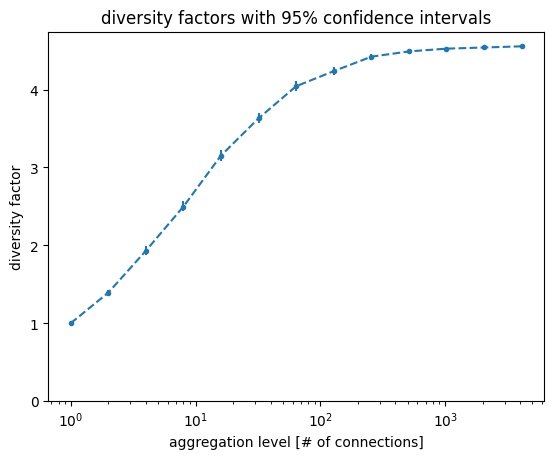

In [487]:
# plot output
pyplot.errorbar(aggregation_levels, average_diversity_factor, yerr=diversity_factor_errors, fmt='.--')
pyplot.xscale('log')
pyplot.ylim(0, None)
pyplot.xlabel('aggregation level [# of connections]')
pyplot.ylabel('diversity factor')
pyplot.title('diversity factors with 95% confidence intervals')
# save a PDF copy
pyplot.savefig('../output/diversity_factor.pdf')